In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
from network_model import *

import sys
#!{sys.executable} -m pip install [arg]
from scipy.stats import gengamma


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [3]:
N = 1000

In [4]:
g = nx.powerlaw_cluster_graph(n=N, m=2, p=0.5)

In [27]:
W, I, communities, gamma_pos, success, allocations, C = simulation(
    NUM_AGENTS=N,
    STEPS=50,
    PROJECT_COST=0.001,
    graph=g,
    seed=123,
    use_data=True,
    DEFAULT_A=0.5
)

191 communities.
Loading pre-computed optimal portfolios...
Performing time stepping...


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


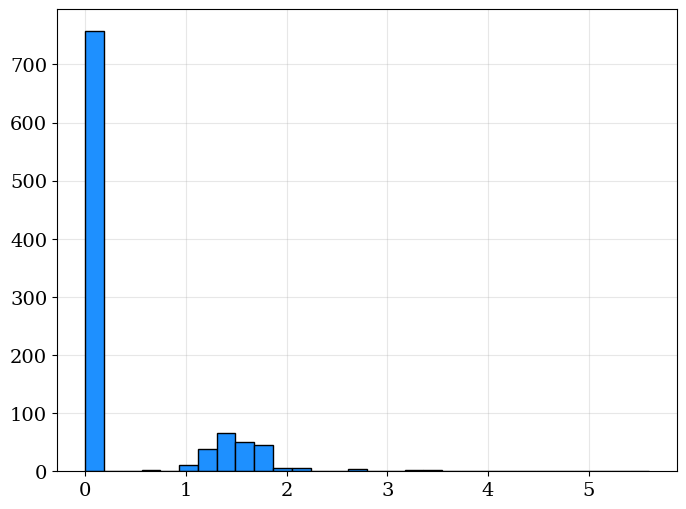

In [28]:
plt.hist(W[-1], bins=30, color="dodgerblue", edgecolor="k")
plt.show()

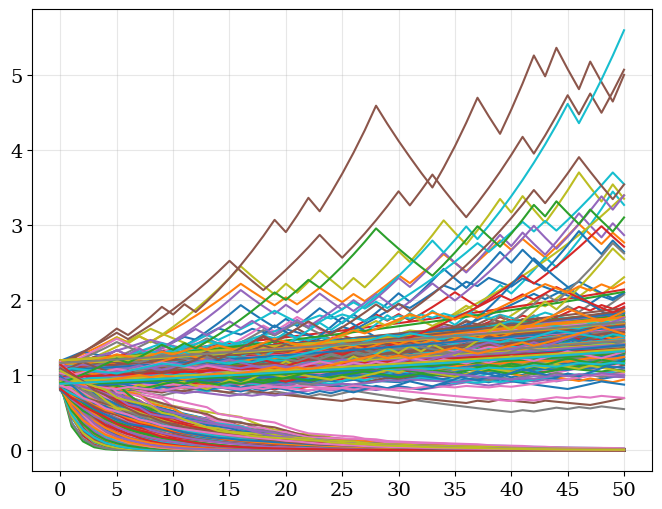

In [29]:
for i in range(W.shape[1]):
    plt.plot(W[:,i])
plt.xticks(np.arange(0, len(W), 5))
plt.show()

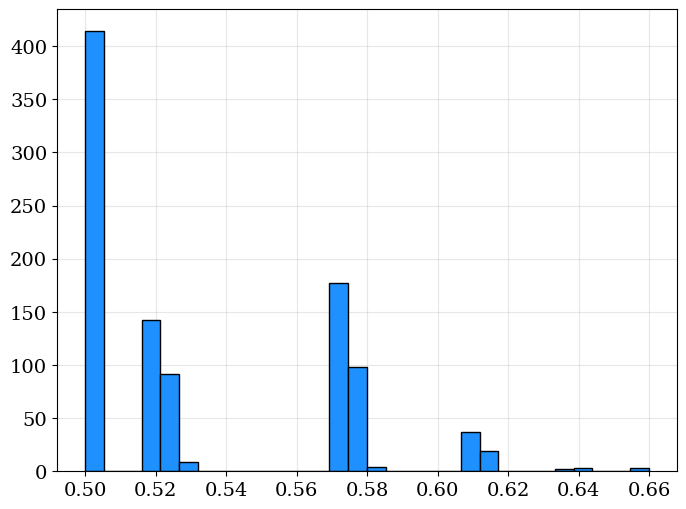

In [15]:
plt.hist(C[-1], color="dodgerblue", edgecolor="k", bins=30)
plt.show()

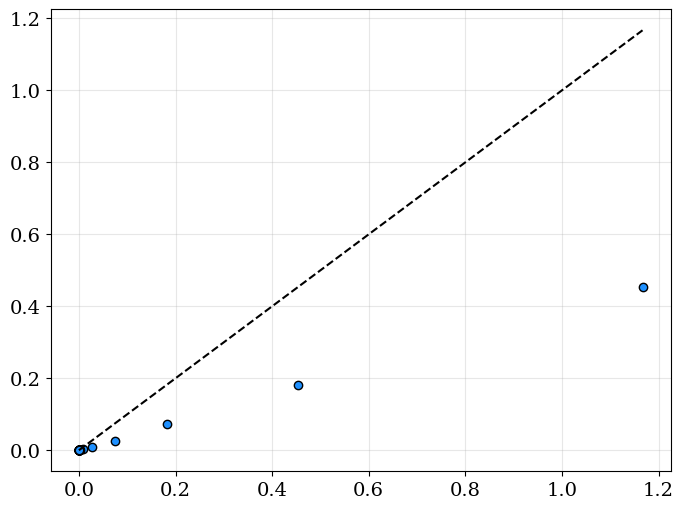

In [13]:
i = 10

x=[]
y=[]
for k in range(len(W)-1):
    x.append(W[k][i])
    y.append(W[k+1][i])

plt.scatter(x,y, color="dodgerblue", edgecolor="k")
plt.plot(np.linspace(min(x), max(x), 100), np.linspace(min(x), max(x), 100), color="k", linestyle="dashed")
plt.show()